In [23]:

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [24]:
train = pd.read_csv(r'C:\Users\lzwDT\PycharmProjects\corona_days\afterCoronaHospital.csv')

# redefine the type error of the 'to_csv'(mainly about int to obeject)
col_dict = {'init_volume_sum':float,
            'is_Emphysema':str,
            'is_Atelectasis':str,
            'degreeOfAlveolarConsolidation':str,
            'is_fibrotic_lesions':str,
            'is_noduleMass':str,
            'is_hollowCavity':str,
            'is_calcification':str,
            'is_pleuralEffusion':str,
            'is_pleuralThickeningAdhesiveCalcification':str,
            'degreeOfBoneHyperplasia':str}
convert_column_name = list(col_dict.keys())
convert_column_name.pop(0)
train[convert_column_name] = train[convert_column_name].astype('int32').astype('object')
print(f'datasets name is \'train\'')
train.info()

datasets name is 'train'
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 51 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   init_volume_sum                            489 non-null    float64
 1   init_volume_sum_per                        489 non-null    float64
 2   init_avg_volume                            489 non-null    float64
 3   final_volume_sum                           489 non-null    float64
 4   final_volume_sum_per                       489 non-null    float64
 5   final_avg_volume                           489 non-null    float64
 6   is_Emphysema                               489 non-null    object 
 7   is_Atelectasis                             489 non-null    object 
 8   degreeOfAlveolarConsolidation              489 non-null    object 
 9   is_fibrotic_lesions                        489 non-null    object 
 10  i

In [25]:
train = train[train.day_hospitalized < 50]
train = train[train.day_hospitalized > 10]


train = train.reset_index()
del train['index']

train['day_divided 3'] = 42
for x in range(train.shape[0]):
    train['day_divided 3'][x] = train['day_hospitalized'][x] / 3

# visualization
#Analysis the data distribution about label 'divided 3'
train_visual = train
train_result = train_visual.groupby('day_divided 3').size()
# plt.bar(list(train_result.index),train_result)
# plt.xlabel('Days')
# plt.ylabel('number')
# plt.title('trainData  \'3 divided\'  ')
# plt.show()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [26]:
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(train,test_size=0.1)

train_data = train_data.reset_index()

test_data = test_data.reset_index()

print(train_data.shape,test_data.shape)

(408, 53) (46, 53)


In [27]:
print(train_data.shape)
print(test_data.shape)

(408, 53)
(46, 53)


In [28]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   index  init_volume_sum  init_volume_sum_per  init_avg_volume  \
0    315             0.00                 0.00              0.0   
1     19           188.02                 7.04           -436.0   
2     13           232.46                 7.05           -455.0   
3    190            16.47                 0.45           -552.0   

   averageLiverFat  day_hospitalized  day_divided 3  
0             18.6                20              6  
1              0.0                12              4  
2             20.2                28              9  
3              8.9                41             13  


# Feature Selection

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


features = pd.read_csv(r'C:\Users\lzwDT\PycharmProjects\corona_days\afterCoronaHospital.csv')

# features.info()
# print(features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
x_data, y_data = train.iloc[:,:-2],train.iloc[:,-1]

#try choose your k best features
k = 12
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
# print(f'Top {k} Best feature score ')
# print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
# print(list(x_data.columns[selected_idx]))

feature_list = list(x_data.columns[selected_idx])




Top 12 Best feature index 
[23 46 28  1 13  8  0 24 27  4 10 45]

Top 12 Best feature name
Index(['cardiothoracic_ratio', 'degreeOfBoneHyperplasia',
       'AbdominalShortDiameterOfTheSameLayer', 'init_volume_sum_per',
       'is_pleuralEffusion', 'degreeOfAlveolarConsolidation',
       'init_volume_sum', 'mainPulmonaryArtery',
       'inferiorVenaCavaShortDiameter', 'final_volume_sum_per',
       'is_noduleMass', 'T12_BMD'],
      dtype='object')


In [30]:
all_features = pd.concat((train_data.iloc[:, selected_idx], test_data.iloc[:, selected_idx]))

all_features = all_features.iloc[:,1:]
# all_features

## 数据预处理



In [31]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [32]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(454, 17)

In [33]:
n_train = train_data.shape[0]

origin_shap_test_features = all_features[n_train:]


shap_train_features = all_features[:n_train].to_numpy()
shap_test_features = all_features[n_train:].to_numpy()

train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['day_divided 3'].values.reshape(-1, 1), dtype=torch.float32)




## [**训练**]



In [34]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,32),
                        nn.LeakyReLU(0.2),
                        nn.BatchNorm1d(32),
                        nn.Dropout(0.2),
                        
                        nn.Linear(32, 16),
                        nn.LeakyReLU(0.2),
                        #nn.BatchNorm1d(10),
                        nn.Dropout(0.1),
                        
                        nn.Linear(16, 1)
                        )
    return net

# LOSS


In [35]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # rmse = torch.sqrt(loss(torch.log(clipped_preds),
    #                        torch.log(labels)))
    
    # MSE :
    rmse = loss(net(features),labels)
    return rmse.item()

Adam 优化器


In [36]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## $K$折交叉验证



In [37]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_train, y_train

当我们在$K$折交叉验证中训练$K$次后，[**返回训练和验证误差的平均值**]。


In [38]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='mse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log mse{float(train_ls[-1]):f}, '
              f'验证log mse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## [**模型选择**]

。


折1，训练log mse59.033360, 验证log mse59.769726
折2，训练log mse47.684811, 验证log mse47.250740
折3，训练log mse58.586678, 验证log mse59.528557
折4，训练log mse50.110607, 验证log mse50.492718
折5，训练log mse49.036022, 验证log mse48.426506
5-折验证: 平均训练log mse: 52.890295, 平均验证log mse: 53.093649


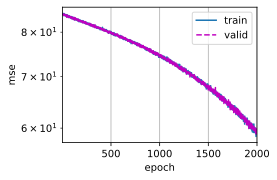

In [39]:
k, num_epochs, lr, weight_decay, batch_size = 5, 2000, 1e-5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log mse: {float(train_l):f}, '
      f'平均验证log mse: {float(valid_l):f}')

# 预测

In [40]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log mse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log mse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    # print(pd.Series(preds.reshape(1, -1)[0]))
    test_data['origin day_divided 3'] = test_data['day_divided 3']
    test_data['day_divided 3'] = pd.Series(preds.reshape(1, -1)[0])
    # print(test_data['day_divided 3'])
    # reValidLoss = loss(test_data['origin day_divided 3'],test_data['day_divided 3'])
    # print(f'reValidLoss MSE :{reValidLoss}')
    submission = pd.concat([test_data['origin day_divided 3'], test_data['day_divided 3']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return net

下面的代码将生成一个名为`submission.csv`的文件。

训练log mse：44.787228


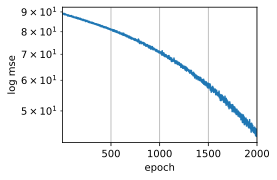

In [41]:
model = train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)

The MSE Loss of test: 47.989952087402344


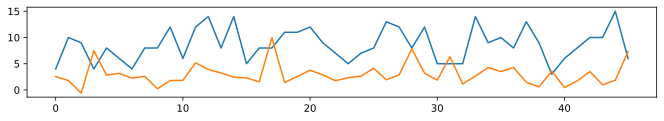

In [42]:
verifyData = pd.read_csv(r'submission.csv')
# verifyData.iloc[:,0].tolist()
# a = verifyData.iloc[:,0].tolist()
origin = torch.FloatTensor(verifyData.iloc[:,0].tolist())
predict = torch.FloatTensor(verifyData.iloc[:,1].tolist())
print(f'The MSE Loss of test: {loss(origin,predict)}')

import matplotlib.pyplot as plt
plt.axes([0, 0, 2.5, 0.5])
plt.plot(origin)
plt.plot(predict)


plt.show()

In [43]:
import pandas as pd 
result1 = pd.read_csv('submission.csv')
result1['day_divided 3']

0     2.551080
1     1.793219
2    -0.593094
3     7.484433
4     2.838332
5     3.151657
6     2.251153
7     2.599188
8     0.227882
9     1.789145
10    1.829619
11    5.180608
12    3.898184
13    3.240868
14    2.443626
15    2.289546
16    1.554417
17    9.962976
18    1.415777
19    2.567301
20    3.763736
21    2.875715
22    1.761873
23    2.335710
24    2.621398
25    4.132139
26    1.942170
27    2.862552
28    7.824506
29    3.192663
30    1.877768
31    6.340011
32    1.132162
33    2.634575
34    4.287611
35    3.505231
36    4.274850
37    1.451300
38    0.582826
39    3.606554
40    0.447138
41    1.719200
42    3.501570
43    0.969315
44    1.859289
45    7.325480
Name: day_divided 3, dtype: float64

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


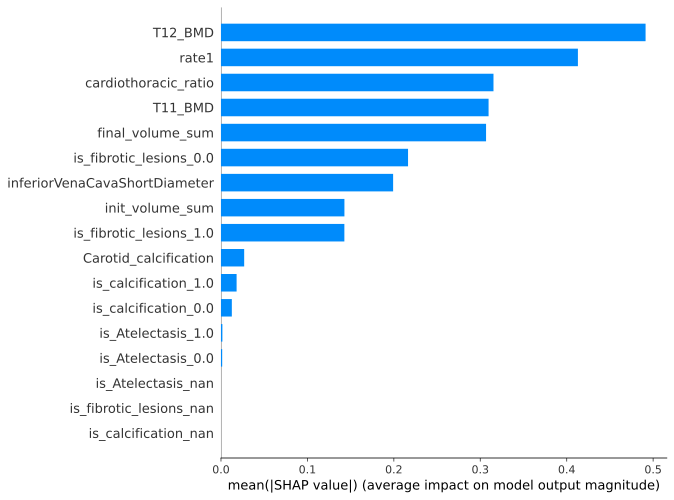

In [44]:
# import shap

# explainer = shap.DeepExplainer(model, shap_train_features)
# shap_values = explainer.shap_values(shap_test_features)
# shap.summary_plot(shap_values, shap_test_features, plot_type='bar')


import shap

explainer = shap.DeepExplainer(model, torch.from_numpy(shap_train_features).float())
shap_values = explainer.shap_values(torch.from_numpy(shap_test_features).float())
shap.summary_plot(shap_values, origin_shap_test_features, plot_type='bar')

接下来，如 :numref:`fig_kaggle_submit2`中所示，
我们可以提交预测到Kaggle上，并查看在测试集上的预测与实际房价（标签）的比较情况。
步骤非常简单：

* 登录Kaggle网站，访问房价预测竞赛页面。
* 点击“Submit Predictions”或“Late Submission”按钮（在撰写本文时，该按钮位于右侧）。
* 点击页面底部虚线框中的“Upload Submission File”按钮，选择你要上传的预测文件。
* 点击页面底部的“Make Submission”按钮，即可查看你的结果。

![向Kaggle提交数据](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/kaggle-submit2.png?raw=1)
:width:`400px`
:label:`fig_kaggle_submit2`

## 小结

* 真实数据通常混合了不同的数据类型，需要进行预处理。
* 常用的预处理方法：将实值数据重新缩放为零均值和单位方法；用均值替换缺失值。
* 将类别特征转化为指标特征，可以使我们把这个特征当作一个独热向量来对待。
* 我们可以使用$K$折交叉验证来选择模型并调整超参数。
* 对数对于相对误差很有用。

## 练习

1. 把你的预测提交给Kaggle，它有多好？
1. 你能通过直接最小化价格的对数来改进你的模型吗？如果你试图预测价格的对数而不是价格，会发生什么？
1. 用平均值替换缺失值总是好主意吗？提示：你能构造一个不随机丢失值的情况吗？
1. 通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。
1. 通过改进模型（例如，层、权重衰减和dropout）来提高分数。
1. 如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？


[Discussions](https://discuss.d2l.ai/t/1824)
